# Preparación

## Importaciones y carga

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel("/home/rom/sankey-derivacions/Derivacions_RM_RCDS_2025_group_sector_regio.xlsx", sheet_name="Sheet1")

## Preprocesamiento

In [6]:

# Normaliza nombres (por si hay espacios invisibles)
df.columns = [c.strip() for c in df.columns]

COL_SOURCE = "UP origen"
COL_TARGET = "UP Destí"
COL_VALUE  = "Total derivacions"

# Limpieza mínima
df[COL_SOURCE] = df[COL_SOURCE].astype(str).str.strip()
df[COL_TARGET] = df[COL_TARGET].astype(str).str.strip()
df[COL_VALUE]  = pd.to_numeric(df[COL_VALUE], errors="coerce").fillna(0).astype(int)

# Grafo (lista de aristas)
edges = df[[COL_SOURCE, COL_TARGET, COL_VALUE]].rename(
    columns={COL_SOURCE:"source", COL_TARGET:"target", COL_VALUE:"w"}
)

print("rows:", len(df))
print("unique sources:", edges["source"].nunique())
print("unique targets:", edges["target"].nunique())
print("total derivations:", int(edges["w"].sum()))
print("edges:", (edges["w"] > 0).sum())


rows: 1300
unique sources: 467
unique targets: 60
total derivations: 181802
edges: 1300


# Procesamiento

## Análisis de dependencias
Mide el grado de dependencia de un nodo respecto a su relación principal dentro de la red.  

Formalmente:
$$
\text{pct\_main} = \frac{\max(w)}{\sum w}
$$
donde:
- $w$ es el peso de cada relación del nodo (por ejemplo, número de remisiones),
- $\max(w)$ es el mayor flujo asociado a una única contraparte,
- $\sum w$ es el volumen total de flujo asociado al nodo.

**Interpretación operativa:**

* ***pct_main ≈ 1:***  El nodo concentra casi todo su flujo en una sola relación → dependencia / concentración extrema.

* ***pct_main ≈ 0.5:*** La relación principal absorbe una parte relevante del flujo → dependencia significativa pero no exclusiva.

* ***pct_main bajo:***: El flujo está repartido entre varias relaciones → nodo diversificado.

Esta métrica es independiente del rol del nodo y se aplica tanto a flujos salientes como entrantes.

### Dependencias por origen

In [18]:
# Dependencia por origen
by_origin = (
    edges
    .groupby("source")
    .apply(
        lambda g: pd.Series({
            "total": g["w"].sum(),
            "main_target": g.loc[g["w"].idxmax(), "target"],
            "main_flow": g["w"].max(),
            "pct_main": g["w"].max() / g["w"].sum()
        })
    )
    .reset_index()
)

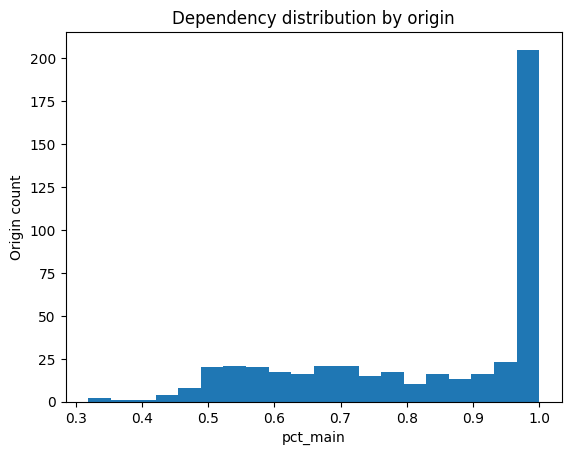

Dependency summary

Total de orígenes: 467
Orígenes con pct_main ≥ 95%: 218 (46.7%)
Orígenes con pct_main ≥ 90%: 243 (52.0%)
Orígenes con pct_main ≥ 85%: 260 (55.7%)


In [19]:
# Histograma de pct_main
plt.hist(by_origin["pct_main"], bins=20)
plt.xlabel("pct_main")
plt.ylabel("Origin count")
plt.title("Dependency distribution by origin")
plt.show()

# Dependency summary
print("Dependency summary\n")
total = len(by_origin)

n_95 = (by_origin['pct_main'] >= 0.95).sum()
n_90 = (by_origin['pct_main'] >= 0.90).sum()
n_85 = (by_origin['pct_main'] >= 0.85).sum()

print(f"Total de orígenes: {total}")
print(f"Orígenes con pct_main ≥ 95%: {n_95} ({n_95 / total:.1%})")
print(f"Orígenes con pct_main ≥ 90%: {n_90} ({n_90 / total:.1%})")
print(f"Orígenes con pct_main ≥ 85%: {n_85} ({n_85 / total:.1%})")

**Interpretación**

- Se aprecia una alta dependencia a un solo destino de casi todos los orígenes `pct_main ≈ 1`.
- Hay un segundo bloque de orígenes con 2 - 3 destinos: `0,5 < pct_main <0,9`
- Hay muy pocos valores bajos de `pct_main` (red no diversificada)

El patrón corresponde a una red jerárquica con rutas preferentes institucionalizadas.

**Nota:** Este gráfico sobrerrepresenta orígenes pequeños (un origen que deriva 5 pacientes a su destino principal pesa igual que uno que deriva 5.000)

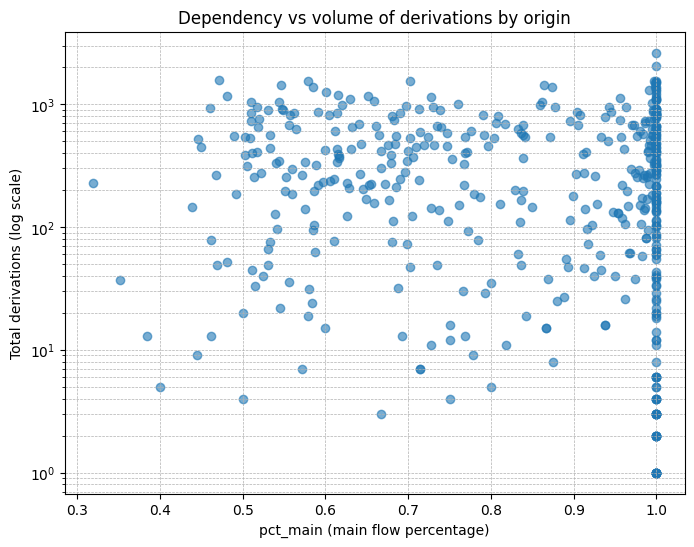

In [20]:
# Gráfico de dispersión: pct_main vs total derivaciones
plt.figure(figsize=(8, 6))
plt.scatter(
    by_origin["pct_main"],
    by_origin["total"],
    alpha=0.6
)

plt.yscale("log")
plt.xlabel("pct_main (main flow percentage)")
plt.ylabel("Total derivations (log scale)")
plt.title("Dependency vs volume of derivations by origin")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


- Alta concentración de derivaciones hacia un único destino por origen.
- Dependencia extrema (`pct_main ≈ 1`) incluso en orígenes de alto volumen.
- Ausencia casi total de grandes emisores con distribución balanceada.
- Patrón consistente con una red jerárquica con rutas preferentes estables y poco flexibles.

### Dependencias por destino

In [22]:
# Dependencia por destino

by_target = (
    edges
    .groupby("target")
    .apply(
        lambda g: pd.Series({
            "total": g["w"].sum(),
            "main_source": g.loc[g["w"].idxmax(), "source"],
            "main_flow": g["w"].max(),
            "pct_main": g["w"].max() / g["w"].sum()
        })
    )
    .reset_index()
)

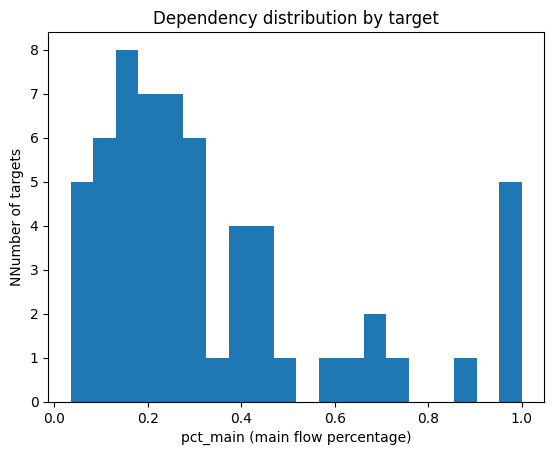

Resumen de dependencia por destino

Total de destinos: 60
Destinos con pct_main ≥ 95%: 5
Destinos con pct_main ≥ 90%: 5
Destinos con pct_main ≥ 85%: 6


In [23]:
# Histograma de dependencia por destino

plt.hist(by_target["pct_main"], bins=20)
plt.xlabel("pct_main (main flow percentage)")
plt.ylabel("NNumber of targets")
plt.title("Dependency distribution by target")
plt.show()

# Resumen de dependencia por destino
print("Resumen de dependencia por destino\n")
print(f"Total de destinos: {len(by_target)}")
print(f"Destinos con pct_main ≥ 95%: {(by_target['pct_main'] >= 0.95).sum()}")
print(f"Destinos con pct_main ≥ 90%: {(by_target['pct_main'] >= 0.9).sum()}")
print(f"Destinos con pct_main ≥ 85%: {(by_target['pct_main'] >= 0.85).sum()}")


**Interpretación**

- Distribución diferente a la de orígenes, con concentración de `pct\_main` bajo o moderado (`≈ 0.1 - 0.4`)
- Solo unos pocos destinos tienen dependencia de un único origen

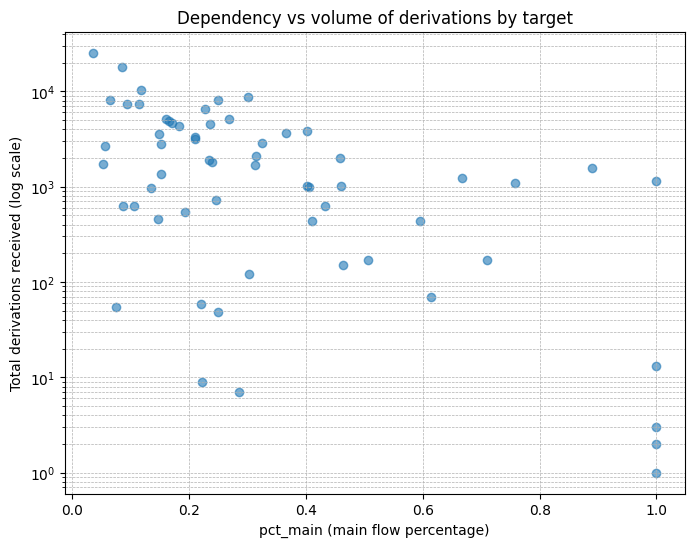

In [24]:
# Dispersión: dependencia vs volumen por destino
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    by_target["pct_main"],
    by_target["total"],
    alpha=0.6
)

plt.yscale("log")
plt.xlabel("pct_main (main flow percentage)")
plt.ylabel("Total derivations received (log scale)")
plt.title("Dependency vs volume of derivations by target")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


- Los destinos de mayor volumen presentan valores bajos de `pct_main`, indicando diversificación de orígenes.
- No se observan destinos grandes con alta dependencia de un único origen.
- La dependencia extrema (`pct_main ≈ 1`) se limita a destinos de muy bajo volumen.
- Los destinos principales actúan como hubs resilientes más que como nodos frágiles.
- La concentración estructural del sistema se localiza en la emisión, no en la recepción.

## Cálculo de ingresos, egresos y balance por centro

In [ ]:
"""
Calcula métricas de balance de flujo (ingresos vs egresos) por centro.

A partir de la tabla de aristas (source → target, w), se agregan los
volúmenes emitidos y recibidos por cada centro y se derivan indicadores
para caracterizar su rol estructural en la red.

Variables calculadas:
- O  (Outflow): volumen total de derivaciones emitidas por el centro.
- I  (Inflow):  volumen total de derivaciones recibidas por el centro.
- R  (In/Out ratio): razón entre ingresos y egresos (I / O); indica
       predominio receptor (R > 1) o emisor (R < 1).
- B  (Balance neto): diferencia absoluta entre ingresos y egresos (I − O).
- NB (Balance normalizado): balance neto normalizado en [-1, 1],
       definido como (I − O) / (I + O), comparable entre centros de
       distinto tamaño.

Consideraciones:
- Centros con O = 0 generan R indefinido (NaN), evitando divisiones por cero.
- NB ≈ −1 identifica emisores netos; NB ≈ +1 receptores netos;
  NB ≈ 0 indica rol mixto o intermediario.
- El resultado describe roles en la red de derivación, no la resolución
  clínica completa.

Devuelve:
- DataFrame indexado por centro con columnas O, I, R, B y NB.
"""


# Egresos por centro (outflow)
outflow = edges.groupby("source")["w"].sum().rename("O")

# Ingresos por centro (inflow)
inflow = edges.groupby("target")["w"].sum().rename("I")

# Unifica por centro
balance = (
    outflow.to_frame()
    .join(inflow, how="outer")
    .fillna(0)
)

# Métricas
balance["R"]  = balance["I"] / balance["O"].replace(0, np.nan)
balance["B"]  = balance["I"] - balance["O"]
balance["NB"] = (balance["I"] - balance["O"]) / (balance["I"] + balance["O"])

balance.head()


,O,I,R,B,NB
source,,,,,
ASSIR Alt Penedès (00253),96.0,0.0,0.0,-96.0,-1.0
ASSIR Montcada i Reixac (01935),6.0,0.0,0.0,-6.0,-1.0
ASSIR Badalona (Casagemes) (00318),49.0,0.0,0.0,-49.0,-1.0
ASSIR Bages (00410),19.0,0.0,0.0,-19.0,-1.0
ASSIR Baix Camp (abans ASSIR Reus) (00075),73.0,0.0,0.0,-73.0,-1.0


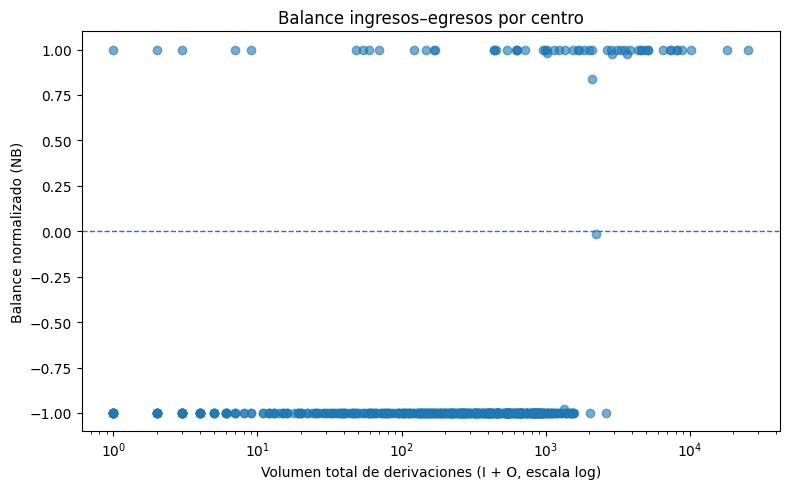

In [ ]:
"""
Genera un gráfico de dispersión que resume el rol estructural de cada centro
en la red de derivaciones, combinando tamaño de actividad y balance de flujo.

Ejes del gráfico:
- Eje X: volumen total de derivaciones del centro (V = I + O),
  representado en escala logarítmica para permitir la comparación entre
  centros pequeños y grandes.
- Eje Y: balance normalizado (NB), definido como (I − O) / (I + O),
  que indica si el centro actúa como emisor neto (NB < 0), receptor neto
  (NB > 0) o tiene un rol mixto (NB ≈ 0).

Elementos visuales:
- Puntos: cada centro de la red.
- Línea horizontal en NB = 0: separa emisores netos de receptores netos.
- Escala log en X: evita que los centros de alto volumen oculten la
  estructura del resto del sistema.

Interpretación:
- La posición vertical refleja el rol funcional del centro.
- La posición horizontal refleja su peso relativo en la red.
- El gráfico permite identificar jerarquías, polarización de roles y
  posibles centros atípicos.

Este gráfico describe la estructura de la red de derivación; no incorpora
información sobre capacidad instalada, tiempos de espera ni resultados
clínicos.
"""


import matplotlib.pyplot as plt
import numpy as np

# Volumen total
balance["V"] = balance["I"] + balance["O"]

plt.figure(figsize=(8,5))
plt.scatter(
    balance["V"],
    balance["NB"],
    alpha=0.6
)

plt.xscale("log")
plt.axhline(0, linestyle="--", linewidth=1)

plt.xlabel("Volumen total de derivaciones (I + O, escala log)")
plt.ylabel("Balance normalizado (NB)")
plt.title("Balance ingresos–egresos por centro")

plt.tight_layout()
plt.show()


- La red muestra una separación casi perfecta de roles entre centros emisores y receptores.
- La dependencia de los emisores es estructural y no depende del volumen de actividad.
- Los mayores volúmenes se concentran en pocos centros receptores netos.
- La arquitectura es jerárquica y fuertemente dirigida, con escasa intermediación.
- El análisis describe la red de derivación, no la atención clínica completa.

In [ ]:
"""
Analiza la concentración del flujo de derivaciones en los centros receptores
(destinos) e identifica los principales hubs de la red.

A partir de una tabla de aristas (source → target, w), se agregan los volúmenes
recibidos por cada destino y se ordenan de mayor a menor para evaluar la
desigualdad en la distribución del flujo entrante.

Variables calculadas:
- I          : volumen total de derivaciones recibidas por cada destino.
- pct_total : proporción del flujo total del sistema que recibe cada destino
               (I / flujo total).
- pct_acum  : proporción acumulada del flujo al ordenar los destinos por
               ingresos descendentes.

Salidas principales:
- Tabla con los 20 destinos con mayor volumen de ingresos (Top 20 hubs).
- Porcentaje del flujo total concentrado en los Top 1, 3, 5, 10 y 20 destinos.

Interpretación:
- Permite cuantificar el grado de concentración del sistema y detectar hubs
  receptores dominantes.
- Describe la distribución del flujo, pero no evalúa riesgo ni resiliencia;
  no introduce escenarios contrafactuales ni sustitución de destinos.

Este análisis corresponde a un enfoque descriptivo de concentración del flujo
en la red de derivación.
"""


# 1) Ingresos por destino (hubs)
hub_in = edges.groupby("target")["w"].sum().sort_values(ascending=False)
total_flow = hub_in.sum()

hubs = hub_in.to_frame("I")
hubs["pct_total"] = hubs["I"] / total_flow
hubs["pct_acum"]  = hubs["pct_total"].cumsum()

# 2) Muestra top 20 y cuánto concentran
print("Total derivaciones:", int(total_flow))
print("\nTop 20 destinos por ingresos:")
display(hubs.head(20))

# 3) Resumen de concentración (top k)
for k in [1, 3, 5, 10, 20]:
    print(f"Top {k}: {hubs['pct_total'].head(k).sum():.2%} del flujo total")


Total derivaciones: 181802

Top 20 destinos por ingresos:


,I,pct_total,pct_acum
target,,,
Institut Diagnòstic Imatge Manso (14634),25510,0.140317,0.140317
Institut Diagnòstic Imatge Girona (04216),18136,0.099757,0.240074
Hospital Universitari Santa Maria (00771),10218,0.056204,0.296278
Hospital Clínic de Barcelona (00718),8764,0.048206,0.344485
Hospital Universitari Mútua de Terrassa (00729),8169,0.044933,0.389418
Centre Mèdic Diagnòstic Alomar - Mataró (15387),8105,0.044581,0.434000
Hospital de Sabadell (00741),7435,0.040896,0.474896
Hospital Sant Rafael (00769),7352,0.040440,0.515335
Hospital de Terrassa (00744),6516,0.035841,0.551177


Top 1: 14.03% del flujo total
Top 3: 29.63% del flujo total
Top 5: 38.94% del flujo total
Top 10: 57.96% del flujo total
Top 20: 80.58% del flujo total


- Un número muy reducido de destinos concentra una proporción elevada del flujo: el **Top-1** recibe ~14% y el **Top-5** casi 40% de todas las derivaciones.
- La concentración crece rápidamente: alrededor de 20 destinos absorben más del 80% del flujo total del sistema.
- El patrón confirma una arquitectura jerárquica deliberada, coherente con un modelo de alta especialización y centralización de capacidad resolutiva.

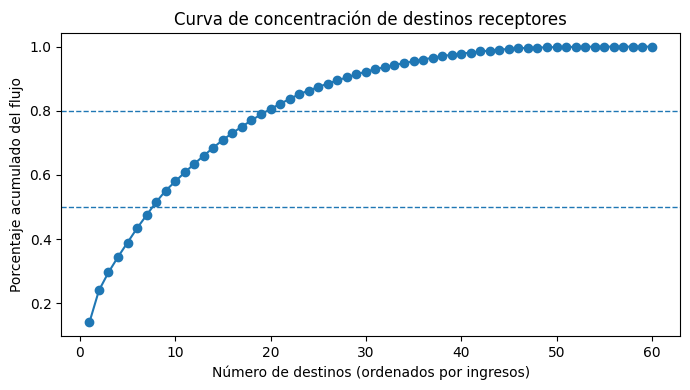

In [ ]:
import matplotlib.pyplot as plt

hubs_reset = hubs.reset_index(drop=True)
hubs_reset["rank"] = range(1, len(hubs_reset) + 1)

plt.figure(figsize=(7,4))
plt.plot(hubs_reset["rank"], hubs_reset["pct_acum"], marker="o")
plt.axhline(0.5, linestyle="--", linewidth=1)
plt.axhline(0.8, linestyle="--", linewidth=1)

plt.xlabel("Número de destinos (ordenados por ingresos)")
plt.ylabel("Porcentaje acumulado del flujo")
plt.title("Curva de concentración de destinos receptores")

plt.tight_layout()
plt.show()


- El flujo de derivaciones está altamente concentrado, ya que un número reducido de destinos acumula una proporción desproporcionada del total.- 
- Aproximadamente la mitad del flujo se concentra en menos de 10 destinos, lo que indica una fuerte centralización funcional.
- Alrededor de 20 destinos concentran cerca del 80% del flujo, evidenciando una distribución muy desigual entre receptores.
- La pendiente inicial pronunciada de la curva refleja la existencia de hubs dominantes en los primeros rangos.
- A partir de cierto número de destinos, la curva se aplana, mostrando que los receptores adicionales aportan marginalmente al volumen total.

In [ ]:
"""
Realiza un stress test estructural de la red de derivaciones simulando la
pérdida de los principales centros receptores (hubs).

A partir del ranking de destinos por volumen de ingresos, se construyen
escenarios contrafactuales en los que los Top-k destinos dejan de estar
disponibles y se cuantifica el impacto directo sobre el flujo total.

Procedimiento:
- Se ordenan los destinos de mayor a menor según ingresos (I).
- Para distintos valores de k (1, 3, 5, 10, 20), se simula la eliminación de
  los Top-k destinos.
- Se calcula el volumen de derivaciones que quedaría sin destino en cada
  escenario, asumiendo que no existe reasignación alternativa.

Variables calculadas:
- k_removed : número de destinos eliminados en el escenario.
- lost_flow : volumen absoluto de derivaciones que se pierden.
- pct_lost  : proporción del flujo total del sistema que se pierde
              (lost_flow / flujo total).

Interpretación:
- Permite identificar umbrales de vulnerabilidad y puntos únicos de fallo.
- Evalúa riesgo sistémico bajo un escenario conservador de fallo completo
  de hubs.
- Complementa el análisis descriptivo de concentración, añadiendo una
  dimensión contrafactual.

Este análisis no incorpora capacidades de absorción ni redirección del flujo;
describe el peor caso estructural de la red de derivación.
"""


# Orden de destinos por ingresos
ordered_targets = hub_in.index.tolist()
total_flow = hub_in.sum()

results = []

for k in [1, 3, 5, 10, 20]:
    removed = set(ordered_targets[:k])
    lost_flow = edges[edges["target"].isin(removed)]["w"].sum()
    results.append({
        "k_removed": k,
        "lost_flow": lost_flow,
        "pct_lost": lost_flow / total_flow
    })

stress = pd.DataFrame(results)
stress


,k_removed,lost_flow,pct_lost
0,1,25510,0.140317
1,3,53864,0.296278
2,5,70797,0.389418
3,10,105373,0.579603
4,20,146499,0.805816


- La eliminación del principal destino receptor implica la pérdida inmediata de ≈14% del flujo total, evidenciando un punto único de fallo relevante.
- La caída conjunta de los tres principales hubs provoca la interrupción de ≈30% del flujo, superando un umbral de estrés severo para el sistema.
- A partir del Top-5 destinos, la pérdida de flujo se acerca al 40%, lo que indica una vulnerabilidad no lineal ante fallos concentrados.
- La eliminación de los Top-10 hubs conduciría a la pérdida de casi 60% del flujo, un escenario compatible con colapso funcional de la red.
- Cuando fallan los Top-20 destinos, se pierde más del 80% del flujo, mostrando que la operatividad del sistema depende críticamente de un conjunto muy reducido de centros.